In [5]:
import shutil, os
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset

reprocess_results=True
dataset_name = "dev"
dpi=120

In [2]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working.yaml')
#really low iou for nms in order to separate out lesions
# cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_fold1/model_final.pth",
#                      "OUTPUT_DIR", "output_valid_"+ dataset_name + "/results"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl
./output


In [3]:
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

In [7]:
from detectron2.modeling import build_model
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
#from plain_train_net import EvaluateClass
from detectron2.evaluation import inference_on_dataset, COCOEvaluator

model = build_model(cfg)  # returns a torch.nn.Module
myloader = build_detection_test_loader(cfg,dataset_name)    
myeval = COCOEvaluator(dataset_name,tasks={'bbox','segm'},output_dir ="output_"+ dataset_name)
for grp in ("fold1", "fold2", "fold3", "fold4","fold5"):
    #build model
    model_weights_path = "output_valid_"+ grp +"/model_final.pth"
    DetectionCheckpointer(model).load(model_weights_path);  # load a file, usually from cfg.MODEL.WEIGHTS
    model.eval(); #set model in evaluation mode
    
    output_dir = "output_"+ dataset_name + "/"+grp
    myeval.reset()
    myeval._output_dir = output_dir
    results_i = inference_on_dataset(model, myloader, myeval)


#%precision 3


In [8]:
len(myeval._predictions) # of images

49

In [18]:

import json
with open("output_"+ dataset_name + "/"+grp+"/coco_instances_results.json") as f:
    preds = json.load(f)
preds[1]

{'image_id': '101001_OS_oct-019.png',
 'category_id': 0,
 'bbox': [159.98500061035156,
  167.7181854248047,
  28.8736572265625,
  9.2569580078125],
 'score': 0.11368856579065323,
 'segmentation': {'size': [496, 1024],
  'counts': '^d^22^?0O1O1O100O1O100O10000000000001O00001O001O001O1N2Obhd<'}}

In [1]:
from Ensembler import Ensembler
ens = Ensembler('output_dev','dev',["fold1", "fold2", "fold3", "fold4","fold5"],.2)
ens.mean_score_nms()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Successfully loaded output_dev/fold1/coco_instances_results.json into memory. 120 instance detected.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Successfully loaded output_dev/fold2/coco_instances_results.json into memory. 125 instance detected.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Successfully loaded output_dev/fold3/coco_instances_results.json into memory. 124 instance detected.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Successfully loaded output_dev/fold4/coco_instances_results.json into memory. 105 instance detected.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Successfully loaded output_dev/fold5/coco_instances_results.json into memory. 112 instance detected.

Wo

In [3]:

ens.save_coco_instances()

In [6]:
from plain_train_net import EvaluateClass
myeval = EvaluateClass(
    dataset_name, "output_"+ dataset_name,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
myeval.evaluate()

Using previously cached COCO format annotations at 'output_dev/dev_coco_format.json'. You need to clear the cache file if your dataset has been modified.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Calculated metrics for 49 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).


(-1.0, 0.0)

In [7]:
myeval.summarize_scalars()


{'dataset': 'dev',
 'precision': -1.0,
 'recall': 0.0,
 'fpr': 0.7551020408163265,
 'iou': 0.2,
 'probability': 0.5}

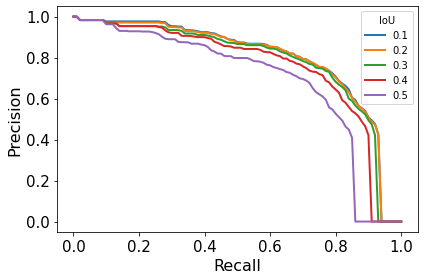

In [51]:
myeval.plot_PRcurve()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'PRCurve_'+dataset_name+'.png'),dpi=dpi)


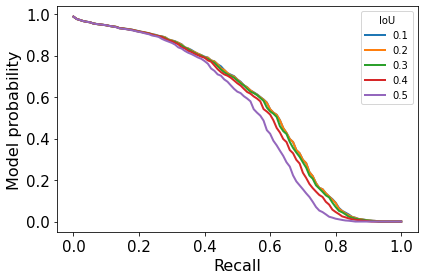

In [52]:
myeval.plot_recall_vs_prob()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'ProbvsRecall_'+dataset_name+'.png'),dpi=dpi)

In [7]:

from plain_train_net import CreatePlotsRPD
RPDplt = CreatePlotsRPD.initfromcoco(myeval.mycoco,myeval.prob_thresh)

In [8]:
RPDplt.dfimg.to_csv(os.path.join(cfg.OUTPUT_DIR,'dfimg_'+dataset_name+'.csv'))
RPDplt.dfpts.to_csv(os.path.join(cfg.OUTPUT_DIR,'dfpts_'+dataset_name+'.csv'))

[0.892 0.976 0.937 0.962 0.884 0.811] [0.761 0.713 0.686 0.667 0.745 0.789] [0.012 0.002 0.003 0.001 0.004 0.005]


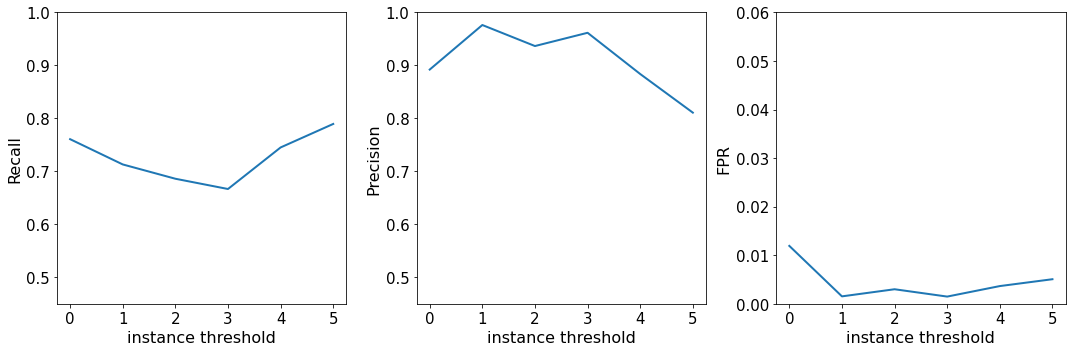

In [9]:
inst = list(range(0,6))
#inst = [4]
pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(RPDplt.dfimg,inst)
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'instance_thresh_scan_level_'+dataset_name+'.png'),dpi=dpi)
print(pr,rc,fpr)

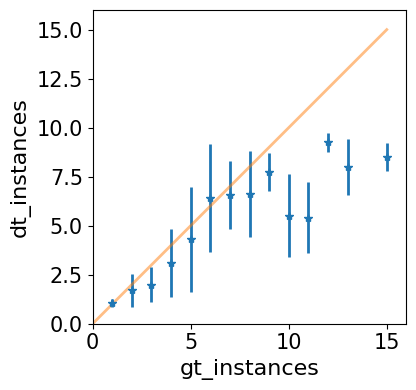

In [10]:
fig = RPDplt.gt_vs_dt_instances()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_instances_'+dataset_name+'.png'),dpi=dpi)

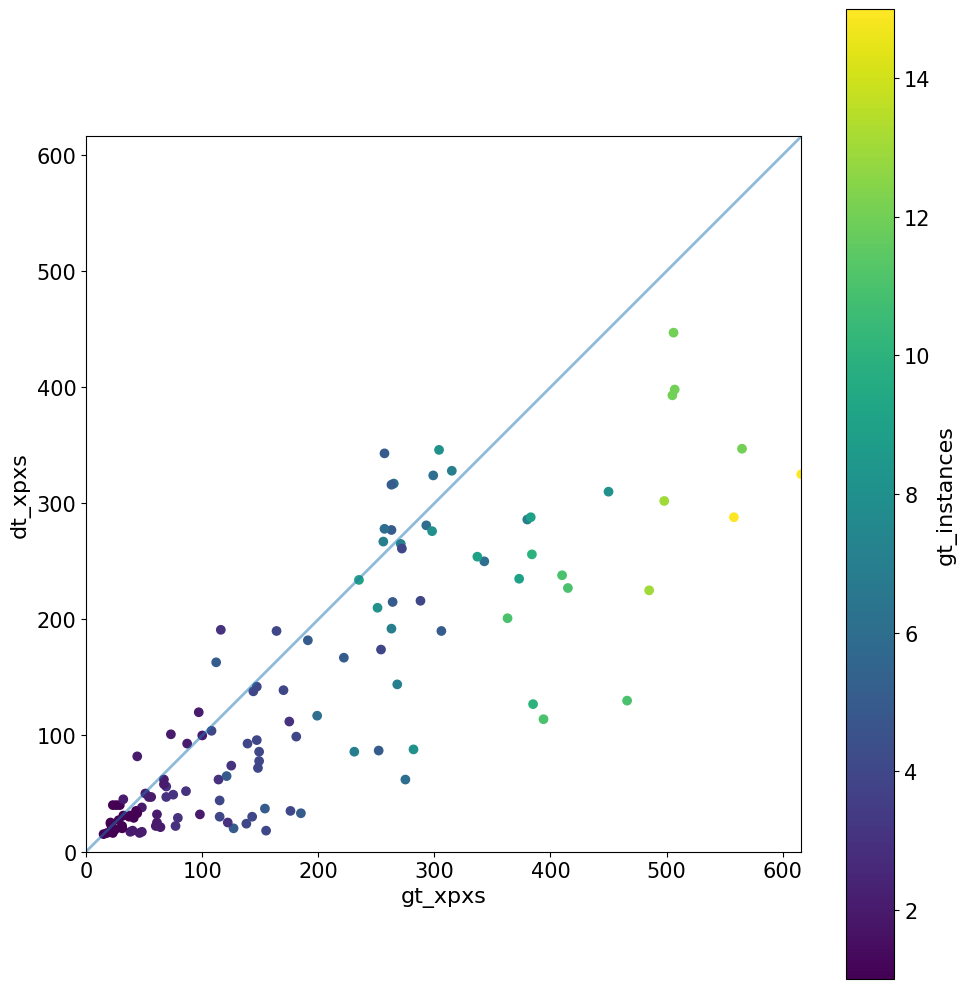

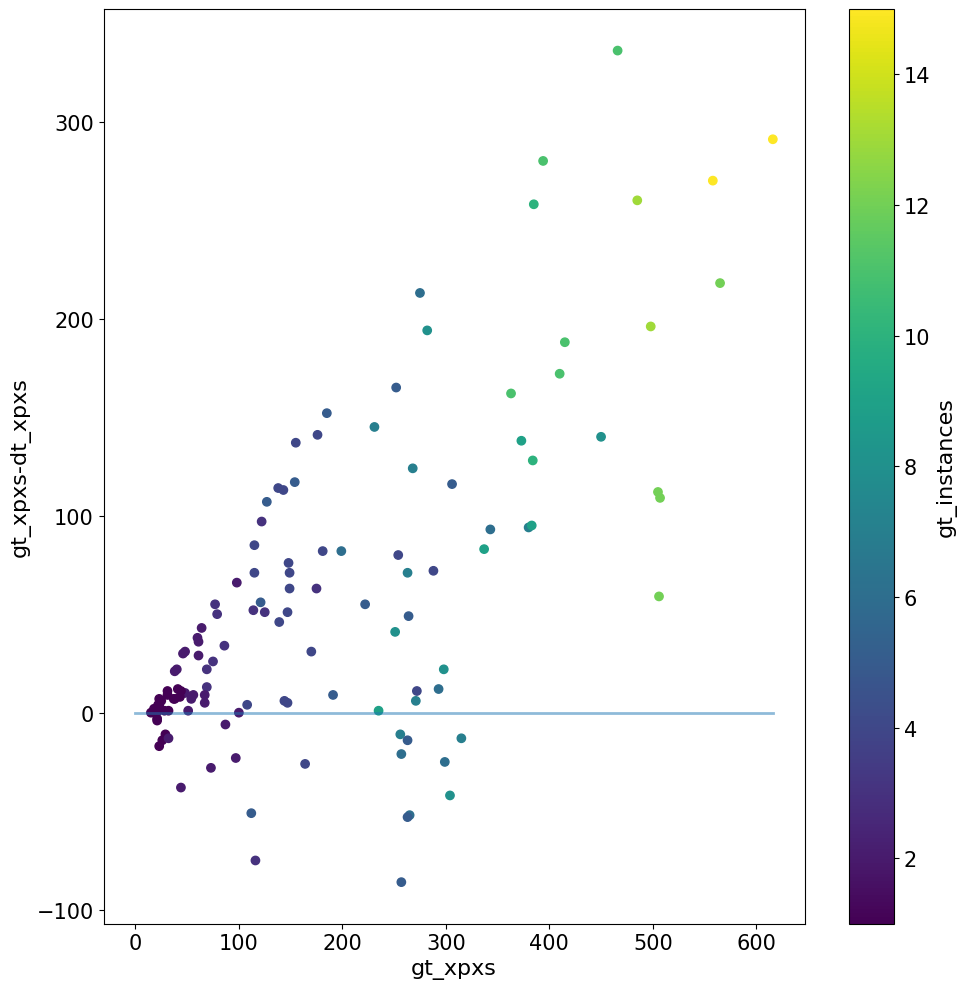

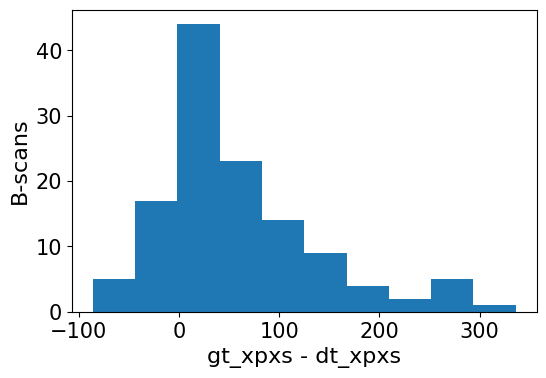

In [11]:
fig1,fig2,fig3 = RPDplt.gt_vs_dt_xpxs()
fig1.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_xpxs_'+dataset_name+'.png'),dpi=dpi)
fig2.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_del_xpxs_'+dataset_name+'.png'),dpi=dpi)

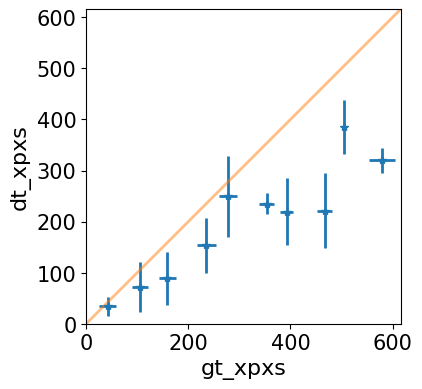

In [12]:
fig = RPDplt.gt_vs_dt_xpxs_mu()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_mu_xpxs_'+dataset_name+'.png'),dpi=dpi)

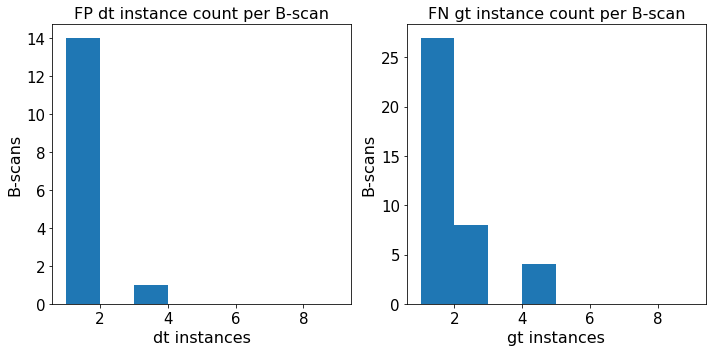

In [13]:
fig = RPDplt.gt_dt_FP_FN_count()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_FP_FN_count_'+dataset_name+'.png'),dpi=dpi)

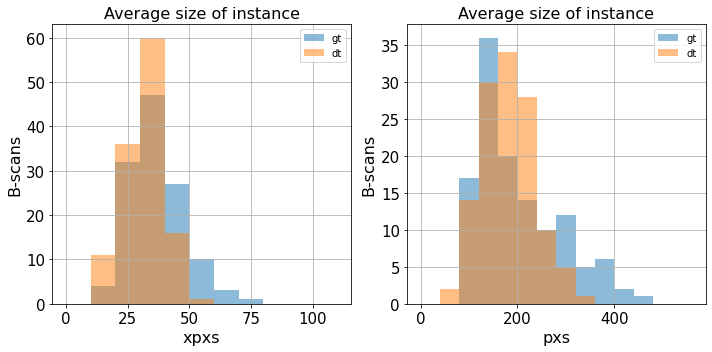

In [14]:
fig = RPDplt.avg_inst_size()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'avg_inst_size_'+dataset_name+'.png'),dpi=dpi)

In [15]:
RPDplt.dfimg

,gt_instances,gt_pxs,gt_xpxs,dt_instances,dt_pxs,dt_xpxs,ptid,eye,scan
102044_OD_oct-012.png,4.0,1078.0,176.0,1.0,254.0,35.0,102044,OD,oct-012
101257_OS_oct-020.png,0.0,0.0,0.0,0.0,0.0,0.0,101257,OS,oct-020
101029_OD_oct-025.png,0.0,0.0,0.0,0.0,0.0,0.0,101029,OD,oct-025
105012_OD_oct-027.png,0.0,0.0,0.0,0.0,0.0,0.0,105012,OD,oct-027
102040_OD_oct-025.png,0.0,0.0,0.0,0.0,0.0,0.0,102040,OD,oct-025
...,...,...,...,...,...,...,...,...,...
101056_OS_oct-044.png,0.0,0.0,0.0,0.0,0.0,0.0,101056,OS,oct-044
102040_OD_oct-014.png,0.0,0.0,0.0,0.0,0.0,0.0,102040,OD,oct-014
102001_OS_oct-042.png,0.0,0.0,0.0,0.0,0.0,0.0,102001,OS,oct-042
101068_OS_oct-042.png,0.0,0.0,0.0,0.0,0.0,0.0,101068,OS,oct-042


In [16]:
#df = RPDplt.dfimg
#from plain_train_net import OutputVis
#vis = OutputVis(dataset_name,cfg,0.5)
#ImgIds = np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:50].values
#vis.output_to_pdf(ImgIds,os.path.join(cfg.OUTPUT_DIR,'top50_xpxs_err_'+dataset_name+'.pdf'),dfimg =myeval.dfimg )

In [17]:
dfpts = RPDplt.dfpts
import pandas as pd
pd.set_option('display.max_rows',500)
dfpts

gt_instances   gt_pxs  gt_xpxs  dt_instances   dt_pxs  dt_xpxs
ptid   eye                                                                
101029 OD            0.0      0.0      0.0           1.0    273.0     46.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
101056 OD            0.0      0.0      0.0           2.0    226.0     34.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
101068 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
101079 OS            6.0   1050.0    222.0           9.0   1348.0    260.0
101257 OD          196.0  30381.0   7207.0         116.0  19802.0   4219.0
       OS          146.0  27493.0   6000.0         106.0  18477.0   3773.0
102001 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
102023 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
102040 OD            0.0      0.0      0.0           2.0    278.0     47.0
       OS            0.0      0.0      0.0           1.0     98.0     16.0
102043 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
102044 OD          117.0  31163.0   4702.0         109.0  24971.0   3842.0
       OS           82.0  25493.0   3585.0          77.0  17900.0   2700.0
102049 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
103030 OD           39.0   5473.0   1084.0          23.0   3764.0    646.0
       OS           60.0   9963.0   1868.0          32.0   5063.0    804.0
104028 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104037 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
105012 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0

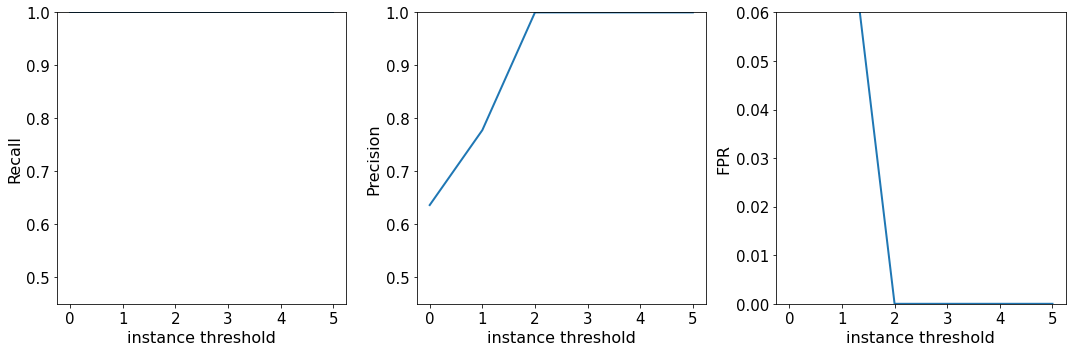

In [18]:
inst = list(range(0,6))
pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(dfpts,inst)

In [5]:
def hover(hover_color="#add8e6"):
    return dict(selector="tbody tr:hover",
            props=[("background-color", "%s" % hover_color)])

styles = [
    #table properties
    dict(selector=" ", 
         props=[("margin","0"),
                ("font-family",'"Helvetica", "Arial", sans-serif'),
                ("border-collapse", "collapse"),
                ("border","none"),
                ("border", "2px solid #ccf")
                   ]),

#     #header color - optional
#     dict(selector="thead", 
#          props=[("background-color","#cc8484")
#                ]),

    #background shading
    dict(selector="tbody tr:nth-child(even)",
         props=[("background-color", "#fff")]),
    dict(selector="tbody tr:nth-child(odd)",
         props=[("background-color", "#eee")]),

    #cell spacing
    dict(selector="td", 
         props=[("padding", ".5em"),("text-align","center")]),

    #header cell properties
    dict(selector="th", 
         props=[("font-size", "125%"),
                ("text-align", "center")]),

    #caption placement
    dict(selector="caption", 
         props=[("caption-side", "bottom")]),

    #render hover last to override background-color
    hover()
]


In [20]:
html_str = dfpts.style.format('{:.0f}').set_table_styles(styles).render()
html_file = open(os.path.join(cfg.OUTPUT_DIR,'dfpts_'+dataset_name+'.html'),'w')
html_file.write(html_str)
html_file.close()

In [21]:
dfpts.style.format('{:.0f}').set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

In [17]:
import json, os
import pandas as pd
mydicts=[]
for name in ['fold1','fold2','fold3','fold4','fold5']:
    with open(os.path.join('output_valid_'+name,'results','scalar_dict_'+name+'.json')) as f:
        mydicts.append(json.load(f))
dfr = pd.DataFrame(mydicts)
pd.set_option('display.precision',2)
dfr.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,dataset,precision,recall,fpr,iou,probability
0,fold1,0.84,0.78,0.05,0.20,0.50
1,fold2,0.64,0.77,0.03,0.20,0.50
2,fold3,0.85,0.62,0.01,0.20,0.50
3,fold4,0.63,0.75,0.03,0.20,0.50
4,fold5,0.55,0.82,0.04,0.20,0.50
